In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/Users/porterjenkins/opt/anaconda3/envs/3dcv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
TRN_MIN = -5
TRN_MAX = 5
TEST_MIN = -6
TEST_MAX = 6

In [44]:
N_TRN = 1000
N_TEST = 500

In [45]:
def generate_data(num_points, x_min, x_max):
    #np.random.seed(42)  # Set a seed for reproducibility

    x_values = np.random.uniform(x_min, x_max, num_points)
    mu_values = np.sin(x_values)
    sigma_values = 0.5 * (1 + np.exp(-x_values)) ** -1
    y_values = np.random.normal(mu_values, sigma_values ** 2)

    return x_values, y_values


In [46]:
def plot_results(x_predicted, y_predicted, y_std):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
    plt.plot(x_predicted, y_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
    plt.fill_between(x_predicted, y_predicted - 3 * y_std, y_predicted + 3 * y_std, color='r', alpha=0.2, label="3 Std Dev")

    plt.axvline(x=-3, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
    plt.axvline(x=3, color='g', linestyle='--', linewidth=2)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-2, 2)
    plt.title('Gaussian DNN Regression')
    plt.legend()
    plt.show()

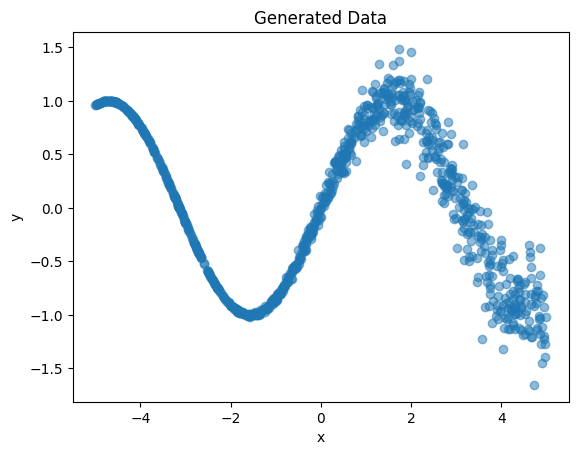

In [47]:
x_values, y_values = generate_data(N_TRN, TRN_MIN, TRN_MAX)

plt.scatter(x_values, y_values, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data')
plt.show()

Great, we've got our model. Now let's fit it with a standard Regression NN.

In [48]:
# Generate data
x_values, y_values = generate_data(num_points=N_TRN, x_min=TRN_MIN, x_max=TRN_MAX)

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x_values, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_values, dtype=torch.float32).unsqueeze(1)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.1, random_state=42)

# Create a DataLoader for training data
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [49]:
# Define the neural network
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [50]:
# Function for training
def train_regression_nn(train_loader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

# Function for evaluation
def evaluate_regression_nn(test_loader, model, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(test_loader.dataset)

In [51]:
# Check for CUDA availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and train the network
model = RegressionNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the network
num_epochs = 100
progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
for epoch in progress_bar:
    train_loss = train_regression_nn(train_loader, model, criterion, optimizer)
    val_loss = evaluate_regression_nn(val_loader, model, criterion)

    progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

Training: 100%|██████████████| 100/100 [00:01<00:00, 56.53epoch/s, Train Loss=0.0216, Val Loss=0.0237]


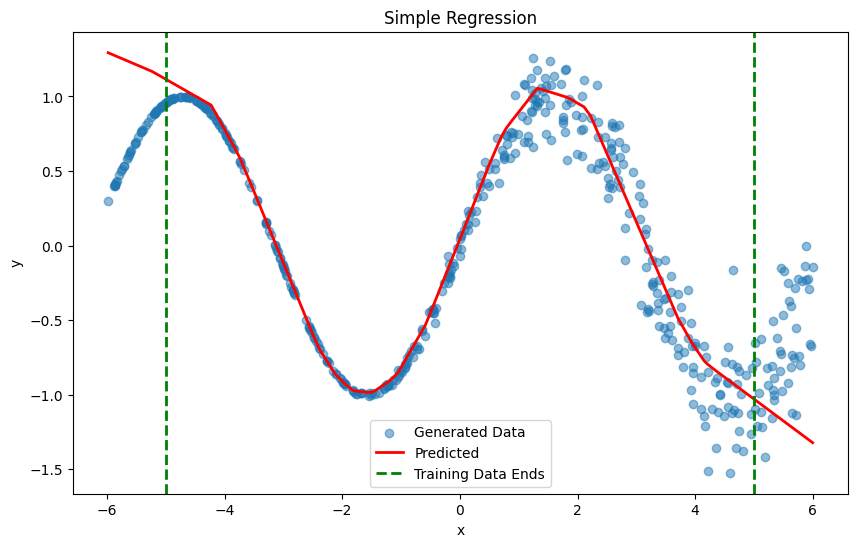

In [54]:
x_values, y_values = generate_data(num_points=N_TEST, x_min=TEST_MAX, x_max=TEST_MIN)

x_for_prediction = np.sort(x_values)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    y_predicted_tensor = model(x_for_prediction_tensor)
    y_predicted = y_predicted_tensor.squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.5, label="Generated Data")
plt.plot(x_for_prediction, y_predicted, label="Predicted", color='r', linestyle='-', linewidth=2)

plt.axvline(x=TRN_MIN, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=TRN_MAX, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Regression')
plt.legend()
plt.show()


It fit the mean quite well. Now let's see about alleatoric uncertainty!

In [55]:
class GaussianDNN(nn.Module):
    def __init__(self):
        super(GaussianDNN, self).__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.mean_output = nn.Linear(32, 1)
        self.logvar_output = nn.Linear(32, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        mean = self.mean_output(x)
        logvar = self.logvar_output(x)
        return mean, logvar


In [56]:
def train_gaussian_dnn(train_loader, model, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        mean, logvar = model(inputs)
        
        loss = 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate_gaussian_dnn(val_loader, model):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            mean, logvar = model(inputs)
            
            loss = 0.5 * (torch.exp(-logvar) * (targets - mean)**2 + logvar).mean()
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(val_loader.dataset)

In [94]:
# Instantiate and train the Gaussian DNN model

lr = 1e-4
num_epochs = 500

gaussian_dnn_model = GaussianDNN().to(device)
optimizer = optim.Adam(gaussian_dnn_model.parameters(), lr=lr)
progress_bar = tqdm(range(num_epochs), desc="Training Gaussian DNN", unit="epoch")
trn_losses = []
val_losses = []
for epoch in progress_bar:
    train_loss = train_gaussian_dnn(train_loader, gaussian_dnn_model, optimizer)
    val_loss = evaluate_gaussian_dnn(val_loader, gaussian_dnn_model)
    
    trn_losses.append(train_loss)
    val_losses.append(val_loss)
    
    progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

Training Gaussian DNN: 100%|█| 500/500 [00:10<00:00, 45.79epoch/s, Train Loss=-2.2163, Val Loss=-2.378


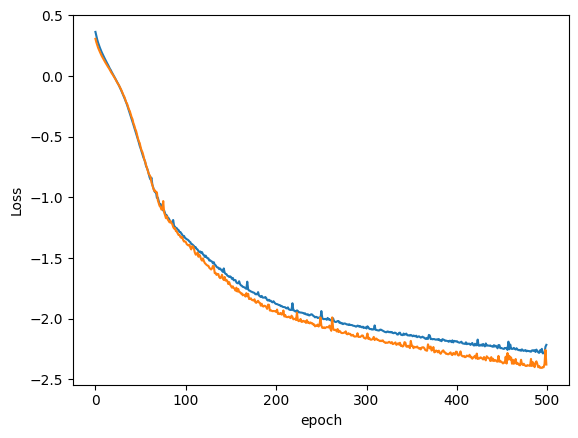

In [95]:
plt.plot(np.arange(num_epochs), trn_losses, label='TRAIN')
plt.plot(np.arange(num_epochs), val_losses, label='VAL')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

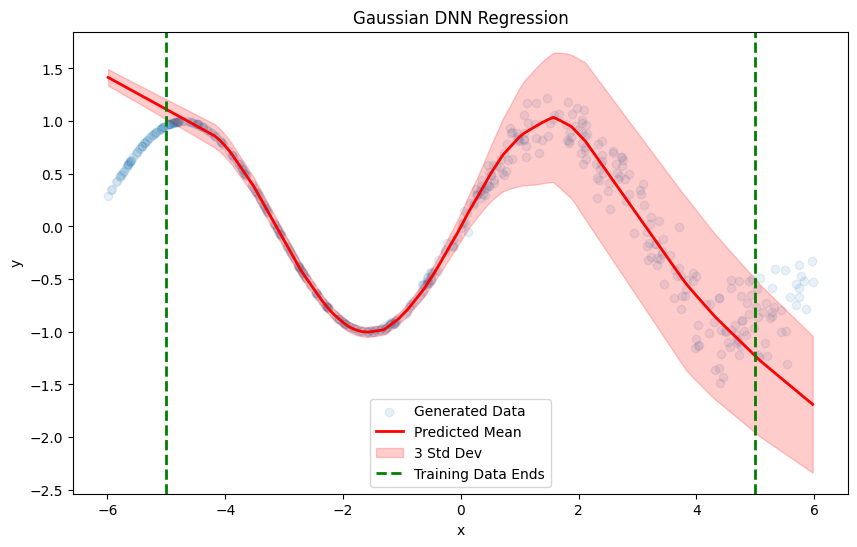

In [107]:
x_values, y_values = generate_data(num_points=N_TEST, x_min=TEST_MIN, x_max=TEST_MAX)

x_for_prediction = np.sort(x_values)
#x_for_prediction = np.linspace(-6, 6, 100)
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    mean_predicted_tensor, logvar_predicted_tensor = gaussian_dnn_model(x_for_prediction_tensor)
    mean_predicted = mean_predicted_tensor.squeeze().numpy()
    std_predicted = np.sqrt(np.exp(logvar_predicted_tensor.squeeze().numpy()))

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, alpha=0.1, label="Generated Data")
plt.plot(x_for_prediction, mean_predicted, label="Predicted Mean", color='r', linestyle='-', linewidth=2)
plt.fill_between(x_for_prediction, mean_predicted - 3 * std_predicted, mean_predicted + 3 * std_predicted, color='r', alpha=0.2, label="3 Std Dev")

plt.axvline(x=TRN_MIN, color='g', linestyle='--', linewidth=2, label="Training Data Ends")
plt.axvline(x=TRN_MAX, color='g', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian DNN Regression')
plt.legend()
plt.show()


It did a great job within the training data bounds, but kinda flopped outside it. Now we'll implement epistemic uncertainty handling with MC Dropout.

In [113]:
squared_error = np.sqrt(np.power((y_values - mean_predicted), 2))

In [114]:
sig_hat = np.sqrt(torch.exp(logvar_predicted_tensor).data.numpy().flatten())

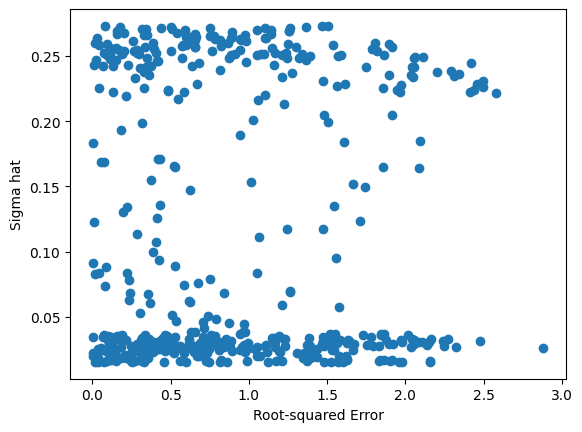

In [118]:
plt.scatter(squared_error, sig_hat)
plt.xlabel("Root-squared Error")
plt.ylabel("Sigma hat")
plt.show()

In [97]:
# looks at two prediction points -2 (high conf.) and 2 (low conf)
x_for_prediction = np.array([-4, -2, 2, 4])
x_for_prediction_tensor = torch.tensor(x_for_prediction, dtype=torch.float32).unsqueeze(1)


In [98]:
with torch.no_grad():
    mean_predicted_tensor, logvar_predicted_tensor = gaussian_dnn_model(x_for_prediction_tensor)
    mean_predicted = mean_predicted_tensor.squeeze().numpy()
    std_predicted = np.sqrt(np.exp(logvar_predicted_tensor.squeeze().numpy()))


In [99]:
mean_predicted_tensor

tensor([[ 0.7638],
        [-0.9108],
        [ 0.8775],
        [-0.6580]])

In [100]:
logvar_predicted_tensor

tensor([[-6.7029],
        [-8.2289],
        [-2.8708],
        [-2.6209]])

In [101]:
np.sqrt(torch.exp(logvar_predicted_tensor).data.numpy().flatten())

array([0.03503422, 0.01633467, 0.23801951, 0.2697047 ], dtype=float32)

In [103]:
y_values.shape

(500,)

In [106]:
mean_predicted.shape

(4,)